In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy as np



# Load INS data
ins_data = pandas.read_csv('csv/3-vectornav-ins.csv')
ins_data = ins_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
ins_data['time'] = pandas.to_datetime(ins_data['time'])
ins_data['time'] = (ins_data['time'] - ins_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
ins_data = ins_data.set_index('time')

# Load GPS Fix (raw) data
fix_data = pandas.read_csv('csv/3-vectornav-fix.csv')
fix_data = fix_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
fix_data['time'] = pandas.to_datetime(fix_data['time'])
fix_data['time'] = (fix_data['time'] - fix_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
fix_data = fix_data.set_index('time')



# Load IMU Data
imu_data = pandas.read_csv('csv/3-vectornav-imu.csv') 
imu_data = imu_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
imu_data['time'] = pandas.to_datetime(imu_data['time'])
imu_data['time'] = (imu_data['time'] - imu_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
imu_data = imu_data.set_index('time')


# Load Pacmod Speed Data
# pacmod parsed_txt/vehicle_speed is gets corrupt rows, so we will use as_tx/vehicle_speed
pacmod_speed = pandas.read_csv('csv/3-pacmod-as_tx-vehicle_speed.csv')
pacmod_speed['time'] = pandas.to_datetime(pacmod_speed['time'])
pacmod_speed['time'] = (pacmod_speed['time'] - pacmod_speed['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
# Additionally, there is an factor offset between parsed_txt/vehicle_speed and as_tx/vehicle_speed for whatever reason
# Use 2.237
pacmod_speed['.data'] = pacmod_speed['.data']*2.237
pacmod_speed = pacmod_speed.set_index('time')

# Load Pacmod Steer Data
pacmod_steer = pandas.read_csv('csv/3-pacmod-parsed_tx-steer_rpt.csv')
pacmod_steer = pacmod_steer.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
pacmod_steer['time'] = pandas.to_datetime(pacmod_steer['time'])
pacmod_steer['time'] = (pacmod_steer['time'] - pacmod_steer['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
pacmod_steer = pacmod_steer.set_index('time')


# Add some basic calculations to dataframes ...

# Mangitude of speed
ins_data['.mag_speed'] = (ins_data['.NedVel.y']**2 + ins_data['.NedVel.x']**2)**(1/2)

# ENU Frame - subtract 90 from yaw
yaw = (90 - ins_data['.RPY.z']) * np.pi/180
ins_x_vel = ins_data['.NedVel.y'] 
ins_y_vel = ins_data['.NedVel.x'] 

# Local velocity at IMU location
ins_data['.LocalVel.x'] = np.multiply(ins_x_vel,np.cos(yaw)) + np.multiply(ins_y_vel,np.sin(yaw))
ins_data['.LocalVel.y'] = -np.multiply(ins_x_vel,np.sin(yaw)) + np.multiply(ins_y_vel,np.cos(yaw))
del yaw, ins_x_vel, ins_y_vel # clear unused variables
ins_data.head()

,.header.seq,.header.frame_id,.Time,.Week,.Status,.RPY.x,.RPY.y,.RPY.z,.LLA.x,.LLA.y,...,.YawUncertainty,.PitchUncertainty,.RollUncertainty,.PosUncertainty,.VelUncertainty,.SyncInTime,.SyncInCount,.mag_speed,.LocalVel.x,.LocalVel.y
time,,,,,,,,,,,,,,,,,,,,,
0.000000,23995,vectornav,1.266946e+09,2094,33542,2.057272,-0.739279,5.663654,30.67242,-96.372515,...,0.309178,0.067305,0.067281,0.737166,0.095215,1.582908e+09,0,0.008869,0.005360,-0.007066
0.019065,23996,vectornav,1.266946e+09,2094,33542,2.058434,-0.738239,5.663603,30.67242,-96.372515,...,0.309263,0.067389,0.067364,0.738043,0.095509,1.582908e+09,0,0.008666,0.005406,-0.006773
0.039128,23997,vectornav,1.266946e+09,2094,774,2.058925,-0.737752,5.663154,30.67242,-96.372515,...,0.309349,0.067472,0.067448,0.738924,0.095803,1.582908e+09,0,0.008481,0.005204,-0.006697
0.059011,23998,vectornav,1.266946e+09,2094,774,2.059210,-0.737454,5.663722,30.67242,-96.372515,...,0.309434,0.067555,0.067531,0.739810,0.096098,1.582908e+09,0,0.008286,0.005036,-0.006580
0.079089,23999,vectornav,1.266946e+09,2094,33542,2.059155,-0.737929,5.663624,30.67242,-96.372515,...,0.309520,0.067638,0.067614,0.740700,0.096392,1.582908e+09,0,0.008350,0.005274,-0.006473


In [3]:
predicted_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading

for steering,time in zip(pacmod_steer['.manual_input'],pacmod_steer.index):
    V = pacmod_speed.iloc[pacmod_speed.index.get_loc(time,method='nearest')]['.data']
    prediction = predicted_yaw[-1] - (V/3.4)*np.tan(steering/20.0)*0.033 # updated equation. 
    prediction = (prediction + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    predicted_yaw.append(prediction)



In [4]:
imu_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading
for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    y0 = imu_data['.Gyro.z'].iloc[i]
    integration = imu_yaw[-1] + (y0)*(t1-t0)
    integration = (integration + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    imu_yaw.append(integration)


## Integrating Yaw

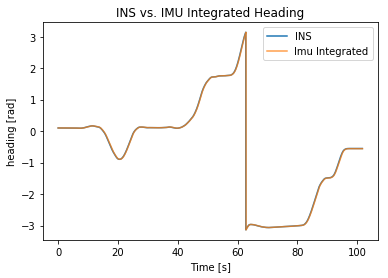

In [5]:
plt.figure()
plt.plot(ins_data.index.values,ins_data['.RPY.z'] * np.pi/180,label='INS') # plot yaw
plt.plot(imu_data.index,imu_yaw,label='Imu Integrated',alpha=0.75)
plt.xlabel('Time [s]')
plt.ylabel('heading [rad]')
plt.title('INS vs. IMU Integrated Heading');
plt.legend()
plt.show();

Integrated yaw looks pretty good actually. Gyro data is probably less noisy than acceleration data. 

## Integrating Acceleration for Velocity

In [6]:
# Perform integration, Initialize to ins_data[0]
imu_vel_x = np.asarray([ins_data['.NedVel.x'].iloc[0]])
imu_vel_y = np.asarray([ins_data['.NedVel.y'].iloc[0]])

for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    v_x0 = imu_data['.Accel.x'].iloc[i]
    v_y0 = imu_data['.Accel.y'].iloc[i]
    vel_x = imu_vel_x[-1] + ( ((v_x0)*(t1-t0)))
    vel_y = imu_vel_y[-1] + ( ((v_y0)*(t1-t0))) 
    imu_vel_x = np.append(imu_vel_x,vel_x)
    imu_vel_y = np.append(imu_vel_y,vel_y)

imu_vel = (imu_vel_x**2 + imu_vel_y**2)**(1/2)


Text(0.5, 1.0, 'Comparison of IMU integrated vs. INS velocity')

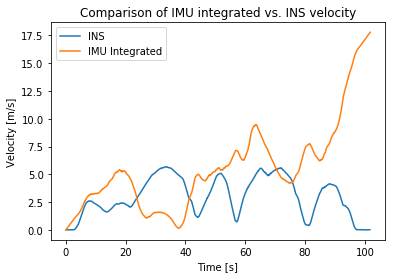

In [7]:
# Plot INS vs Imu Integrated velocity
plt.plot(ins_data.index,ins_data['.mag_speed'],label='INS')
plt.plot(imu_data.index,imu_vel,label="IMU Integrated")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.title('Comparison of IMU integrated vs. INS velocity')

### Where does this drift come from?

Let's observe some acceleration data when the velocity of the golfcart is zero (observed when the magnitude of the GPS speed is < 0.01 m/s)

In [8]:
v_is_zero = ins_data['.mag_speed'] < 1e-2
v_is_zero = ins_data[v_is_zero]['.mag_speed'] >= 0.0
v_is_zero = v_is_zero.index[v_is_zero]

imu_when_zeroV = pandas.DataFrame(columns=imu_data.columns)
for t in v_is_zero:
    imu = imu_data.iloc[imu_data.index.get_loc(t,method='nearest')]
    imu_when_zeroV = imu_when_zeroV.append(imu)
imu_when_zeroV.describe()

,.gps_time,.Mag.x,.Mag.y,.Mag.z,.Accel.x,.Accel.y,.Accel.z,.Gyro.x,.Gyro.y,.Gyro.z,.Temp,.Pressure
count,1.000000e+02,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0
mean,1.266946e+09,0.0,0.0,0.0,-0.312736,-0.153232,-9.766966,0.000067,-0.000003,-0.000015,0.0,0.0
std,4.863606e+01,0.0,0.0,0.0,0.153943,0.157563,0.024637,0.001170,0.000860,0.000759,0.0,0.0
min,1.266946e+09,0.0,0.0,0.0,-0.516115,-0.380444,-9.821852,-0.002065,-0.002715,-0.001544,0.0,0.0
25%,1.266946e+09,0.0,0.0,0.0,-0.442355,-0.343320,-9.782477,-0.000827,-0.000449,-0.000582,0.0,0.0
50%,1.266946e+09,0.0,0.0,0.0,-0.406985,-0.051076,-9.768445,0.000023,-0.000046,-0.000020,0.0,0.0
75%,1.266946e+09,0.0,0.0,0.0,-0.132130,-0.023278,-9.753196,0.000847,0.000529,0.000545,0.0,0.0
max,1.266946e+09,0.0,0.0,0.0,-0.086527,0.066165,-9.675923,0.003721,0.002181,0.002124,0.0,0.0


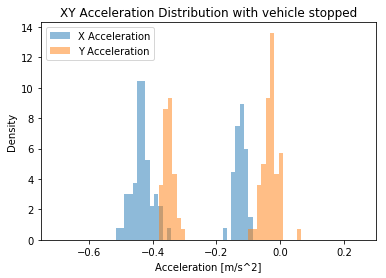

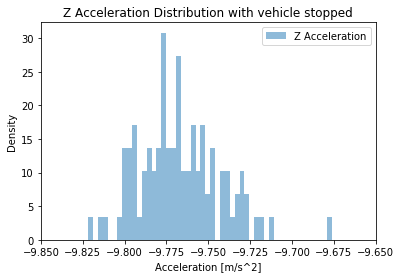

In [21]:
plt.figure()
plt.hist(imu_when_zeroV['.Accel.x'],bins=32,alpha=0.5,label="X Acceleration",density=True)
plt.hist(imu_when_zeroV['.Accel.y'],bins=32,alpha=0.5,label="Y Acceleration",density=True)
plt.xlim([-0.75,0.3])
plt.xlabel('Acceleration [m/s^2]')
plt.ylabel('Density')
plt.title('XY Acceleration Distribution with vehicle stopped')
plt.legend()
plt.figure()

plt.hist(imu_when_zeroV['.Accel.z'],bins=50,alpha=0.5,density=True,label="Z Acceleration")
plt.xlim([-9.85,-9.65])
plt.xlabel('Acceleration [m/s^2]')
plt.ylabel('Density')
plt.title('Z Acceleration Distribution with vehicle stopped')
plt.legend();

In [10]:
# Code accelerations by stop
imu_when_zeroV['group'] = None
c_time = imu_when_zeroV.index[0]
group = 0
for t in imu_when_zeroV.index:
    if np.abs(c_time - t) > 10: # Seperation time in seconds. Tune according to dataset
        group += 1
        c_time = t
    imu_when_zeroV.at[t,'group'] = group
    #print(t,group)
    #print(imu_when_zeroV)

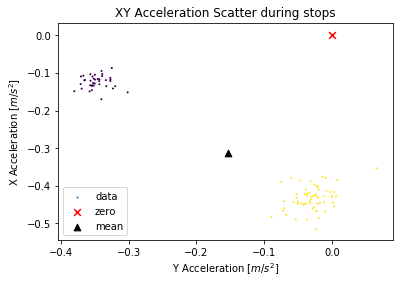

In [12]:
plt.title('XY Acceleration Scatter during stops')
plt.scatter(imu_when_zeroV['.Accel.y'],imu_when_zeroV['.Accel.x'],s=1,c=imu_when_zeroV['group'],label='data')
plt.scatter(0.0,0.0,s=45,color='red',label='zero',marker='x')
plt.scatter(imu_when_zeroV['.Accel.y'].mean(),imu_when_zeroV['.Accel.x'].mean(),s=45,marker='^',color='k',label='mean')
plt.xlabel('Y Acceleration [$m/s^2$]')
plt.ylabel('X Acceleration [$m/s^2$]');
plt.legend()

## Subtracting out the bias, and re-integrating

In [19]:
bx = imu_when_zeroV['.Accel.x'].mean()
by = imu_when_zeroV['.Accel.y'].mean()

# Perform integration, Initialize to ins_data[0]
imu_vel_x = np.asarray([ins_data['.NedVel.x'].iloc[0]])
imu_vel_y = np.asarray([ins_data['.NedVel.y'].iloc[0]])

for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    v_x0 = imu_data['.Accel.x'].iloc[i]  - bx
    v_y0 = imu_data['.Accel.y'].iloc[i]  - by
    vel_x = imu_vel_x[-1] + ( ((v_x0)*(t1-t0)))
    vel_y = imu_vel_y[-1] + ( ((v_y0)*(t1-t0))) 
    imu_vel_x = np.append(imu_vel_x,vel_x)
    imu_vel_y = np.append(imu_vel_y,vel_y)

imu_vel = (imu_vel_x**2 + imu_vel_y**2)**(1/2)

Text(0.5, 1.0, 'Comparison of IMU integrated vs. INS velocity')

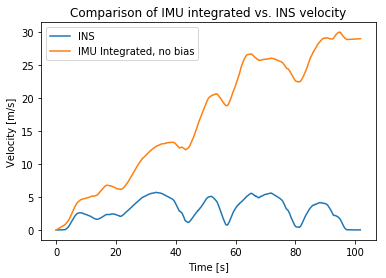

In [20]:
# Plot INS vs Imu Integrated velocity
plt.plot(ins_data.index,ins_data['.mag_speed'],label='INS')
plt.plot(imu_data.index,imu_vel,label="IMU Integrated, no bias")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.title('Comparison of IMU integrated vs. INS velocity')